In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract, sql

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Use Inspector to print the column names and types
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# Use Inspector to print the column names and types
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Previewing Measurement Table
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [13]:
# Previewing Station table
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [14]:
# Getting date of last precipitation measurement
results = session.query(extract('year',Measurement.date),extract('month',Measurement.date), extract('day',Measurement.date)).order_by(Measurement.date.desc()).limit(1)
last_date = results[0]
last_date

(2017, 8, 23)

In [16]:
# Calculate the date 1 year ago from the last data point in the database
one_yr_prior = dt.datetime(last_date[0]-1,last_date[1], last_date[2])

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_yr_prior).\
    order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame 
df = pd.DataFrame(results[:], columns=['date', 'precipitation'])

df = df.dropna()

# set the index to the date column
df = df.set_index('date')

# preview df
df.head(10)

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08
2016-08-25,0.00


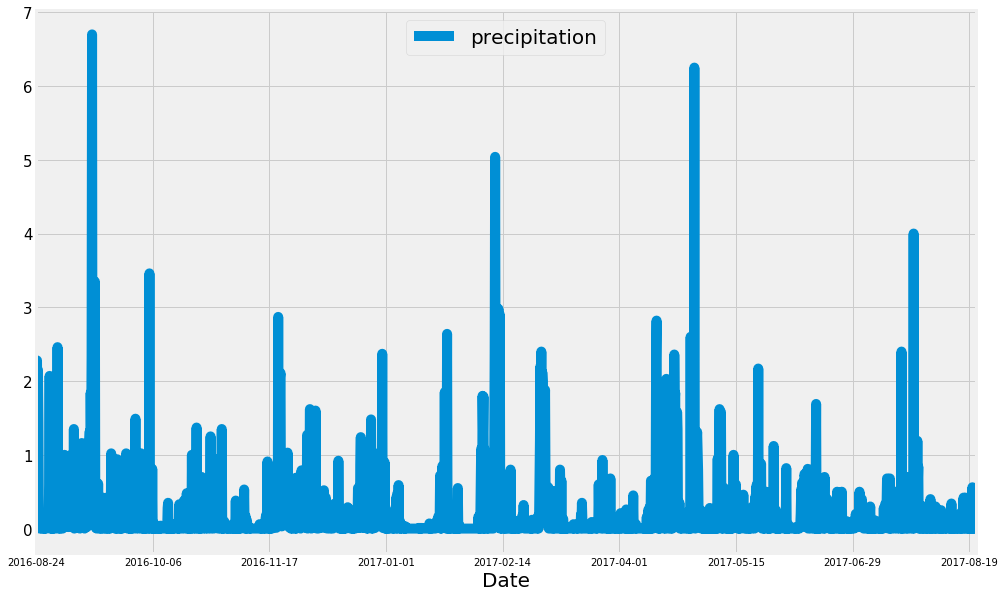

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='line', figsize=(15,10), linewidth=10)
plt.legend(fontsize = 20 , loc="upper center")
plt.xlabel("Date", fontsize = 20)
plt.yticks(fontsize = 15)

plt.savefig("Precipitation plot.png")
plt.show()

In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(station_count)

9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# Listing the stations and the counts in descending order.
results2 = session.query(Station.station, Station.name, func.count(Measurement.id)).\
           filter(Station.station == Measurement.station).\
           group_by(Station.id).\
           order_by(func.count(Measurement.id).desc())

df2 = pd.DataFrame(results2, columns=['Station', 'Station Name', "Observations"])
df2

,Station,Station Name,Observations
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [25]:
# Filter by the station with the highest number of tobs
results3 = session.query(Station.station, Station.name, Measurement.tobs).\
           filter(Station.station == Measurement.station).\
           filter(Measurement.date >= one_yr_prior).\
           filter(Station.station == results2[0][0]).\
           order_by(Measurement.tobs.asc())

df3 = pd.DataFrame(results4, columns=['Station', 'Station Name', "tobs"])

df3.head()

,Station,Station Name,tobs
0,USC00519281,"WAIHEE 837.5, HI US",59.0
1,USC00519281,"WAIHEE 837.5, HI US",59.0
2,USC00519281,"WAIHEE 837.5, HI US",59.0
3,USC00519281,"WAIHEE 837.5, HI US",60.0
4,USC00519281,"WAIHEE 837.5, HI US",60.0


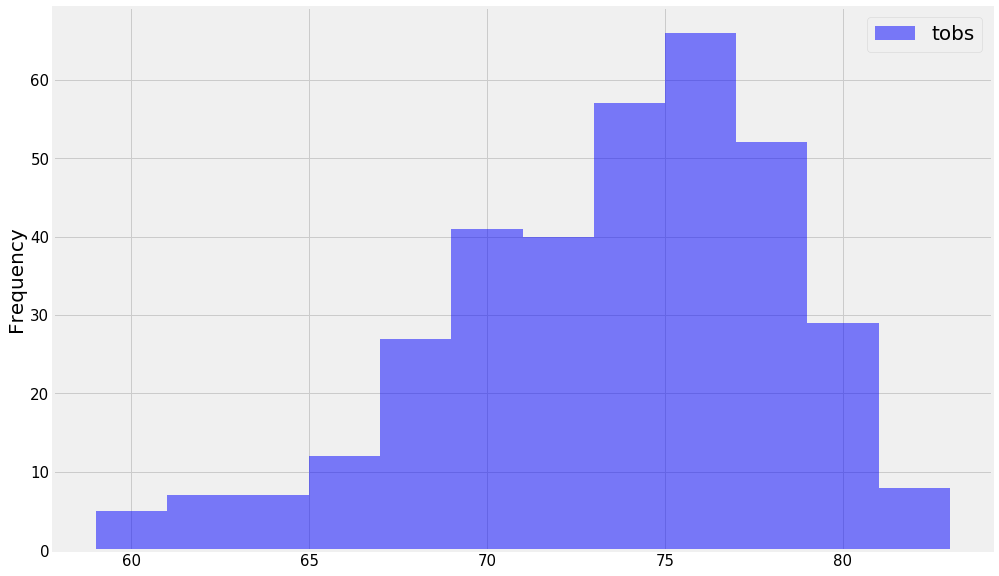

In [26]:
# plot the result as a histogram with bins = 12

num_bins = 12

plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(df3["tobs"], num_bins, facecolor='blue', alpha=0.5, label = 'tobs')
    
plt.legend(fontsize = 20 , loc="best")
plt.ylabel('Frequency', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.savefig("Station Histogram.png")
plt.show()